## View and Vet an Exoplanet

Given a target name that was observed by Kepler. Pull down all the data. Flatten it. Fold it.
Examine a few things to see if other things could make it a false positive, like an eclipsing binary.

Define our inputs:
targetname={{TARGETNAME}}  #This is a Kepler Input Catalog Integer
period={{PERIOD}}  #This is a float
tzero. #this is float

In [103]:
#targetname={{TARGETNAME}}
#tzero={{TZERO}}
#period={{PERIOD}}
targetname=9002278
period=122.3873978 #Days
tzero= 54982.90234 #MJD
tzero_bkjd=150.41158 #We need times in bkjd to be consistent with Kepler.
notebook_url="http://localhost:8892"

In [104]:
#from lightkurve import KeplerTargetPixelFile
%matplotlib notebook
from lightkurve import KeplerLightCurveFile
from lightkurve import LightCurve
import numpy as np
import matplotlib.pyplot as plt

In [105]:
def getAllQuartersLc(targetname,period):
    times=[]
    sapfluxes=[]
    pdcfluxes=[]
    for i in np.arange(17)+1:
        lcf=KeplerLightCurveFile.from_archive(targetname, quarter=i)
        times.append(lcf.SAP_FLUX.time)
        sapfluxes.append(lcf.SAP_FLUX.flux)
        pdcfluxes.append(lcf.PDCSAP_FLUX.flux)
        
        
    saplc=LightCurve(time=np.concatenate(times).ravel(),flux=np.concatenate(sapfluxes).ravel())
    pdclc=LightCurve(time=np.concatenate(times),flux=np.concatenate(pdcfluxes))

    return saplc,pdclc

In [106]:
saplc,pdclc=getAllQuartersLc(targetname,period)

### Plot a flattened normalized lightcurve

In [107]:
#ADJUST THE NUMBER OF CADENCES IN THE FLATTENING HERE.
n_cadences=251
#sapflat = saplc.flatten(window_length=n_cadences)
pdcflat = pdclc.flatten(window_length=n_cadences)

/Users/smullally/anaconda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<IPython.core.display.Javascript object>


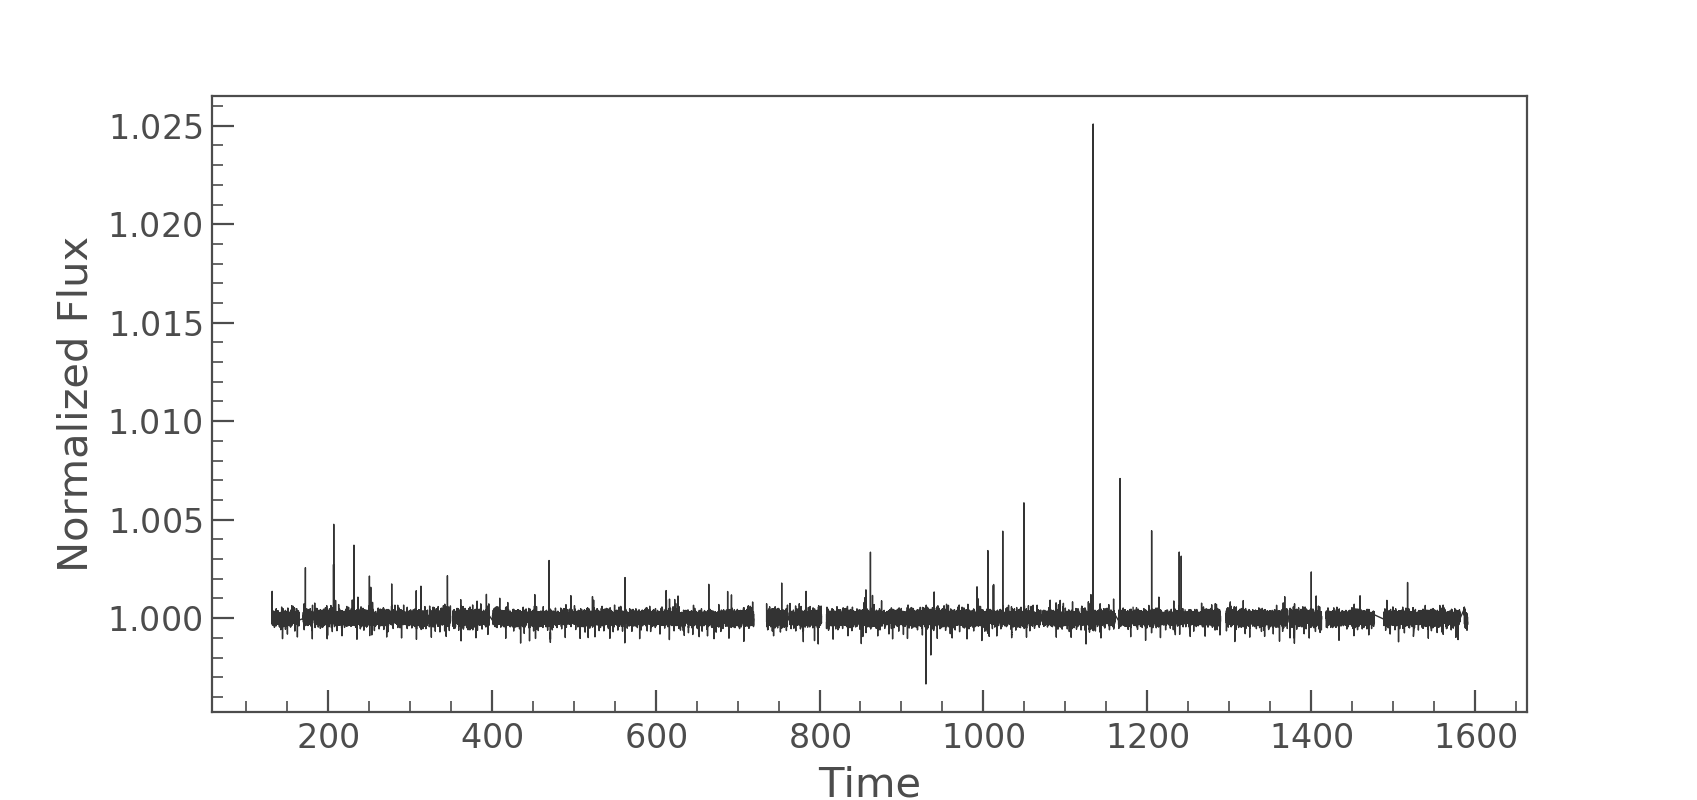

In [108]:
#sapflat.plot(title="SAP_FLUX Lightcurve")
pdcflat.plot(title="PDCSAP_FLUX Lightcurve")

### Plot Folded

<IPython.core.display.Javascript object>


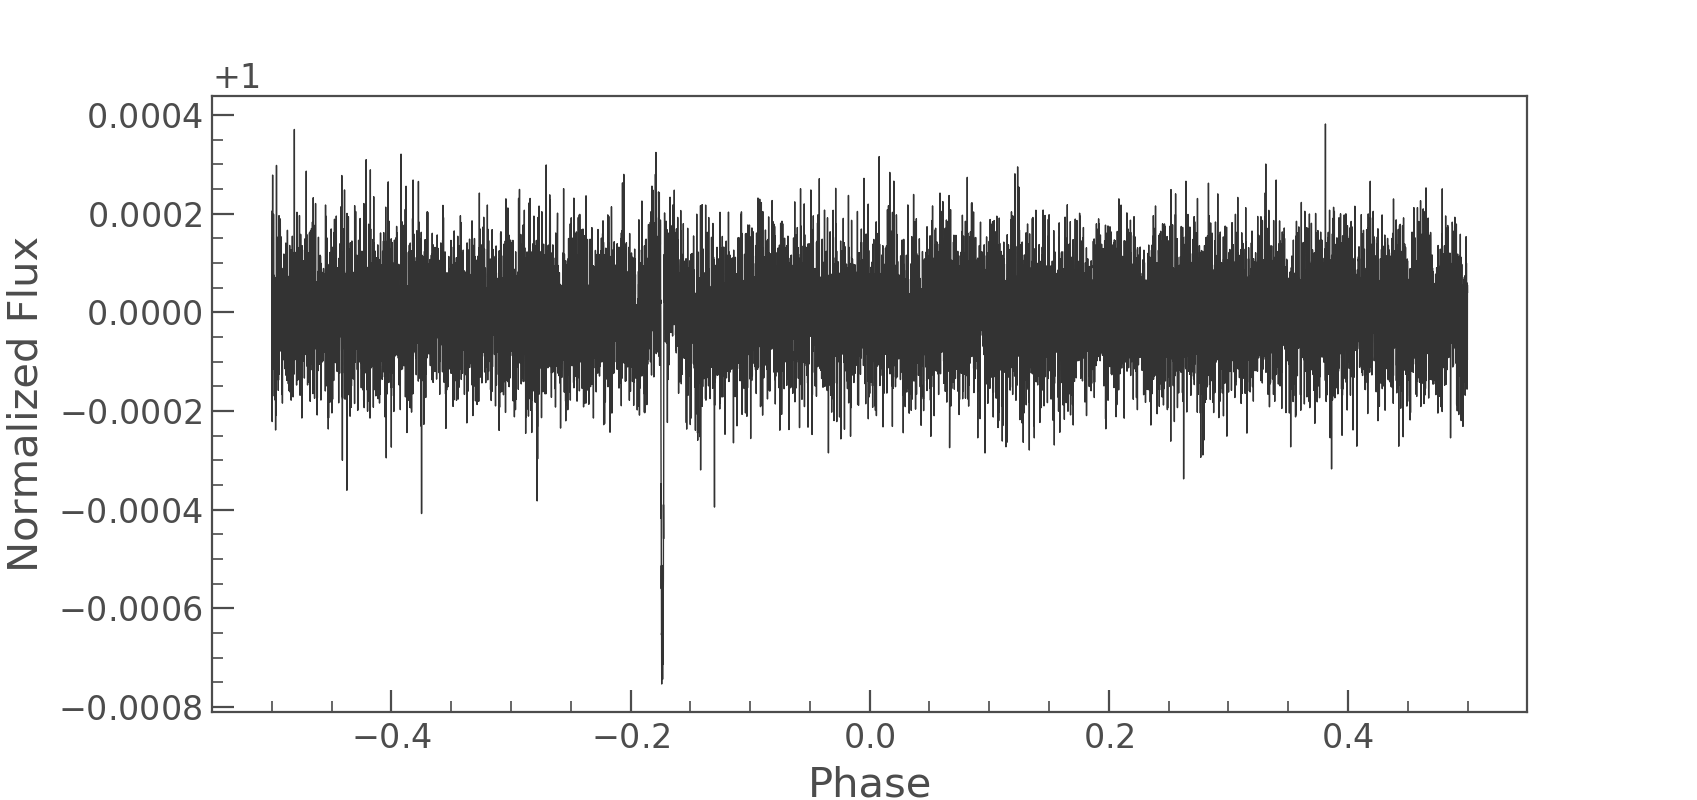

In [67]:
#sapfold=sapflat.fold(period,phase=tzero_bkjd)
#Phases are in sapfold.phase
#sapbin=sapfold.bin(binsize=5,method='median')
#sapbin.plot(title="SAP Folded Binned")
pdcfold=pdcflat.fold(period,phase=tzero_bkjd)
#Phases are in sapfold.phase
pdcbin=pdcfold.bin(binsize=5,method='median')
pdcbin.plot(title="PDC Folded Binned")

### Define a bokeh plot that zooms in around one transit, but shows SAP, PDC and PDC Folded


In [109]:
import re

import numpy as np

from astropy.table import Table, Column

from bokeh.plotting import figure,show
from bokeh.models import Range1d, Label, Slider
from bokeh.embed import components, file_html
from bokeh.resources import CDN
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from bokeh.layouts import row,layout
from bokeh.models.widgets import Button, RadioButtonGroup, Select, Slider

# Putting the plot colors at the top so they can be changed more easily if needed
LINE_COLOR = "#FF6600"
OUTLINE_COLOR = "#02465C"
FILL_COLOR = "#30ECF2"

In [110]:
ntransitsmin=np.floor((saplc.time[0]-tzero_bkjd)/period)
ntransitsmax=np.ceil((saplc.time[-1]-tzero_bkjd)/period)
transittimes=tzero_bkjd+period*np.arange(ntransitsmin,ntransitsmax) #Global
width=0.3*3 #Global
print(ntransitsmin,ntransitsmax)

-1.0 12.0


In [114]:
def plot_flux_time_transit(lcList,ctime,titles):
    """
    Plot one plot per light curve centered on the integer transit number with time width sepcifified in days.
    Done in Bokeh so slider bars are possible later.
    """
    
    plots=[]
    for i,lc in enumerate(lcList):
        
        plots.append( figure(title=titles[i], toolbar_location="above",x_axis_label='TIME(BKJD)', \
                          y_axis_label='relative flux', plot_width=320, plot_height=300, \
                          tools="pan,box_zoom,wheel_zoom,reset,save"))
        if (i==0):
            plots[i].x_range=Range1d(ctime-width/2, ctime+width/2)
        else:
            plots[i].x_range=plots[0].x_range
            
        want=(lc.time>(ctime-width/2)) & (lc.time<(ctime+width/2))   

        try:
            plots[i].scatter(lc.time,lc.flux)
            plots[i].y_range=Range1d(np.min(lc.flux[want]),np.max(lc.flux[want])*1.02)             

        except ValueError:
            pass
        
    return plots
    

In [115]:
def show_ui(doc):
        
    lcList=[saplc,pdclc,pdcflat]
    lcTitles=['SAP','PDC','PDC_Flat']

    ttime=transittimes[0]

    plots=plot_flux_time_transit(lcList,ctime=ttime,titles=lcTitles)
    def slider_callback(attr,old,new):
        ctime=transittimes[int(new-ntransitsmin)]
        plots[0].x_range.start=ctime-width/2
        plots[0].x_range.end=ctime+width/2
    
    slider = Slider(start=ntransitsmin, end=ntransitsmax, value=ntransitsmin, step=1, title="Which Transit Number")
    lc_layout=layout([plots,[slider]])

    slider.on_change('value',slider_callback)
    
    doc.add_root(lc_layout)



In [116]:
output_notebook()
show(show_ui, notebook_url=notebook_url)

Loading BokehJS ...

ERROR:bokeh.server.protocol_handler:error handling message Message 'PATCH-DOC' (revision 1): IndexError('index 13 is out of bounds for axis 0 with size 13',)


In [85]:
lc.flux

NameError: name 'lc' is not defined